**imports**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, silhouette_score
from sklearn.model_selection import train_test_split
from mlxtend.frequent_patterns import fpgrowth, association_rules
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
import seaborn as sns


**Loading the Dataset**

In [ ]:
stroke_data_table = pd.read_csv('healthcare-dataset-stroke-data.csv')  # Loading data to pandas format

# **General Preprocessing**

In [ ]:
# Replace 'Unknown' with NaN in smoking_status
stroke_data_table['smoking_status'] = stroke_data_table['smoking_status'].replace('Unknown', pd.NA)

# Fill missing values
stroke_data_table['bmi'] = stroke_data_table['bmi'].fillna(stroke_data_table['bmi'].median())
stroke_data_table['ever_married'] = stroke_data_table['ever_married'].fillna(stroke_data_table['ever_married'].mode()[0])
stroke_data_table['Residence_type'] = stroke_data_table['Residence_type'].fillna(stroke_data_table['Residence_type'].mode()[0])

# Convert binary categoricals
stroke_data_table['ever_married'] = stroke_data_table['ever_married'].map({'Yes': 1, 'No': 0})
stroke_data_table['Residence_type'] = stroke_data_table['Residence_type'].map({'Urban': 1, 'Rural': 0})

# Restore 'Unknown' for smoking_status and one-hot encode categorical columns
stroke_data_table['smoking_status'] = stroke_data_table['smoking_status'].fillna('Unknown')
df = pd.get_dummies(stroke_data_table, columns=['gender', 'work_type', 'smoking_status'], drop_first=True)




---


**Balancing Data & Prepearing for FP-Growth**

In [ ]:
# ---------------------------
# Balance the Dataset (for Association Rule Mining)
# ---------------------------
df_majority = df[df['stroke'] == 0]
df_minority = df[df['stroke'] == 1]
df_balanced = pd.concat([
    df_majority.sample(n=len(df_minority), random_state=42),
    df_minority
]).reset_index(drop=True)

# ---------------------------
# Prepare Data for FP-Growth
# ---------------------------
df_trans = df_balanced.copy()

# Bin continuous variables
df_trans['age'] = pd.cut(df_trans['age'], bins=[0, 30, 50, 100], labels=['young', 'middle-aged', 'old'])
# BMI Binning
df_trans['bmi'] = pd.cut(df_balanced['bmi'],
                         bins=[0, 18.5, 25, 30, 35, df_balanced['bmi'].max()+1],
                         labels=['underweight', 'normal', 'overweight', 'obese', 'extremely obese'])

# Glucose Level Binning
df_trans['avg_glucose_level'] = pd.cut(df_balanced['avg_glucose_level'],
                                       bins=[0, 70, 100,  df_balanced['avg_glucose_level'].max()+1],
                                       labels=['hypoglycemic', 'normal', 'diabetic/hyperglycemic'])



# Convert all columns to string to prepare for one-hot
df_trans = df_trans.astype(str)

# One-hot encode all attribute-value pairs (turn into transactional data)
df_encoded = pd.get_dummies(df_trans)

print("Shape of encoded transactional dataset:", df_encoded.shape)

Shape of encoded transactional dataset: (498, 536)


**Applying FP-Growth**

In [ ]:
# ---------------------------
# Make Rules Readable
# ---------------------------

def map_feature_name(item):
    """Maps encoded feature names to human-readable labels."""
    item = str(item)
    if '_False' in item:
        label = item.replace('_False', '')
        return f"{label.replace('_', ' ')} is False"
    elif '_True' in item:
        label = item.replace('_True', '')
        return f"{label.replace('_', ' ')} is True"
    elif '_' in item and any(x in item for x in ['young', 'middle-aged', 'old', 'low', 'medium', 'high']):
        feature, value = item.split('_', 1)
        return f"{feature.replace('_', ' ')} is {value}"
    elif 'stroke_1' in item:
        return "stroke = Yes"
    elif 'stroke_0' in item:
        return "stroke = No"
    return item.replace('_', ' ')

def prettify_rule(antecedents, consequents):
    """Formats a rule in human-readable form."""
    antecedent_str = ", ".join(map(map_feature_name, antecedents))
    consequent_str = ", ".join(map(map_feature_name, consequents))
    return f"If [{antecedent_str}] → Then [{consequent_str}]"


In [ ]:
# ---------------------------
# Apply FP-Growth Algorithm
# ---------------------------
frequent_itemsets = fpgrowth(df_encoded, min_support=0.4, use_colnames=True)
print("Top Frequent Itemsets:")
print(frequent_itemsets.sort_values('support', ascending=False).head())

# ---------------------------
# Extract Association Rules
# ---------------------------
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
rules = rules.sort_values(['confidence', 'lift'], ascending=False)


# Filter rules that predict stroke = 1
stroke_rules = rules[rules['consequents'].astype(str).str.contains('stroke_1')]


# Apply to DataFrame
stroke_rules = stroke_rules.copy()  # Add this before modifying it
stroke_rules['rule'] = stroke_rules.apply(
    lambda row: prettify_rule(row['antecedents'], row['consequents']),
    axis=1
)

# Format for display
readable = stroke_rules[['rule', 'support', 'confidence', 'lift']].copy()
readable['support'] = readable['support'].apply(lambda x: f"{x:.2%}")
readable['confidence'] = readable['confidence'].apply(lambda x: f"{x:.2%}")
readable['lift'] = readable['lift'].apply(lambda x: f"{x:.2f}")

# Show top rules
print("\nTop Stroke-Related Rules (Readable):")


from tabulate import tabulate # For fixing space formating
print(tabulate(readable.head(10), headers='keys', tablefmt='plain', showindex=False))

Top Frequent Itemsets:
     support                                           itemsets
0   1.000000                               (gender_Other_False)
1   0.997992                     (work_type_Never_worked_False)
20  0.997992  (gender_Other_False, work_type_Never_worked_Fa...
21  0.935743     (gender_Other_False, work_type_children_False)
2   0.935743                         (work_type_children_False)

Top Stroke-Related Rules (Readable):
rule                                                                                                                        support    confidence      lift
If [age is old] → Then [stroke = Yes, work type children is False]                                                          45.38%     68.90%          1.39
If [age is old, gender Other is False] → Then [stroke = Yes, work type children is False]                                   45.38%     68.90%          1.39
If [age is old] → Then [gender Other is False, stroke = Yes, work type children is Fals

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)




---
# **K-Means-Clustering**





> **Run only the General Preprocessing before running the code segment below**



## **Basic Clustrering - First Attempt**

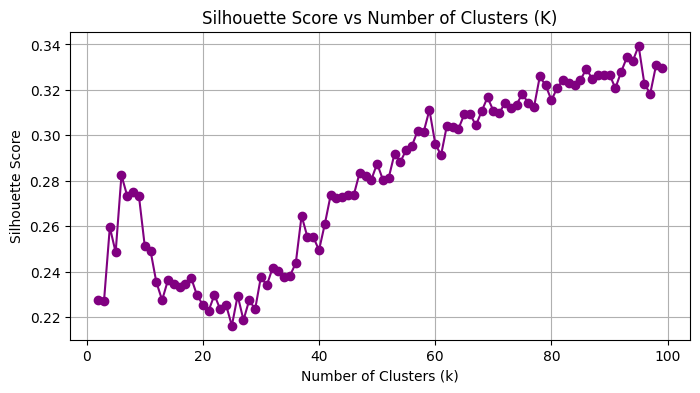

Best K based on silhouette score: 95

Stroke distribution per cluster:
stroke          0         1
cluster                    
0        0.969697  0.030303
1        0.978022  0.021978
2        0.976471  0.023529
3        1.000000  0.000000
4        0.913043  0.086957
...           ...       ...
90       0.866667  0.133333
91       0.857143  0.142857
92       0.840909  0.159091
93       1.000000  0.000000
94       0.942029  0.057971

[95 rows x 2 columns]


In [ ]:
# Drop columns not useful for clustering
X = df.copy()
X = X.drop(columns=['id', 'stroke'])  # 'stroke' is the target, but we don't use it for clustering

# Standardize the features (important for K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Try KMeans with different numbers of clusters (k)
silhouette_scores = []
k_range = range(2, 100)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # random_state = 42 makes the same output every run (for testing) <---------------
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(k_range, silhouette_scores, marker='o', color = 'purple')
plt.title('Silhouette Score vs Number of Clusters (K)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Choose the best K and re-run KMeans
best_k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Best K based on silhouette score: {best_k}")

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Optional: Analyze how stroke is distributed in each cluster
print("\nStroke distribution per cluster:")
print(df.groupby('cluster')['stroke'].value_counts(normalize=True).unstack().fillna(0))

In [ ]:
# ------------------------------------
# Show Overall Stroke Rate
# ------------------------------------
total_patients = len(df)
total_strokes = df['stroke'].sum()
stroke_rate = total_strokes / total_patients * 100
print(f"\nOverall stroke rate in full dataset: {stroke_rate:.2f}% ({int(total_strokes)} out of {total_patients})")

# ------------------------------------
# Stroke Distribution per Cluster (Stroke=1 only, normalized to 100%)
# ------------------------------------
print("\nStroke=1 distribution across clusters (adds up to 100%) with counts:")

stroke_1 = df[df['stroke'] == 1]
stroke_0 = df[df['stroke'] == 0]

# Percentage of stroke=1 per cluster (normalized to 100%)
stroke_1_dist = stroke_1['cluster'].value_counts(normalize=True).sort_index() * 100
stroke_1_counts = stroke_1['cluster'].value_counts().sort_index()
stroke_0_counts = stroke_0['cluster'].value_counts().sort_index()

# Ensure all clusters appear (even if 0 counts)
all_clusters = sorted(df['cluster'].unique())

for cluster_id in all_clusters:
    percent = stroke_1_dist.get(cluster_id, 0)
    stroke1_count = stroke_1_counts.get(cluster_id, 0)
    stroke0_count = stroke_0_counts.get(cluster_id, 0)
    stroke_rate_in_cluster = (stroke1_count / (stroke1_count + stroke0_count)) * 100 if (stroke1_count + stroke0_count) > 0 else 0
    print(f"Cluster {cluster_id}: {percent:.2f}% of all stroke=1 "
      f"(overall cluster patients={stroke1_count + stroke0_count}) "
      f"=> stroke rate in cluster: {stroke_rate_in_cluster:.2f}%")



# ------------------------------------
# Cluster Size (for context)
# ------------------------------------
print("\nNumber of patients per cluster:")
print(df['cluster'].value_counts().sort_index())

# ------------------------------------
# Average Medical Features per Cluster
# ------------------------------------

print(("-----------------------------------------------------------------------------------------------------------------------------"))
print(df.dtypes)

print(("-----------------------------------------------------------------------------------------------------------------------------"))
# Show all feature map
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

print("\nAverage medical features per cluster (age, BMI, glucose, etc.):")
feature_means = df.groupby('cluster')[
    ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease']
].mean().round(2)
print(feature_means.to_string())
feature_means.to_csv("cluster_numeric_features_means.csv") # Saving as CSV for later use (maybe)

print("-----------------------------------------------------------------------------------------------------------------------------")
# Select boolean columns only
bool_cols = df.select_dtypes(include='bool').columns

# Compute mean (proportion of True) per cluster
print("\nProportion of 'True' for boolean features per cluster:")
bool_means = df.groupby('cluster')[bool_cols].mean().round(2)
print(bool_means.to_string())
bool_means.to_csv("cluster_boolean_features_means.csv") # Saving as CSV for later use (maybe)

print("-----------------------------------------------------------------------------------------------------------------------------")
all_features = pd.concat([
    df.groupby('cluster')[['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease']].mean().round(2),
    df.groupby('cluster')[bool_cols].mean().round(2)
], axis=1)

print("\nCombined cluster averages (numeric + boolean):")
print(all_features.to_string())
all_features.to_csv("cluster_all_features_means.csv") # Saving as CSV for later use (maybe)

# ------------------------------------
# Most Common Categorical Features per Cluster
# ------------------------------------

print("-----------------------------------------------------------------------------------------------------------------------------")
print("\nCluster categorical traits per cluster:")
for cluster_id in  sorted(df['cluster'].unique()):
    print(f"\nCluster {cluster_id}:")
    cluster_data = df[df['cluster'] == cluster_id].drop(columns=['id', 'cluster', 'stroke'])
    print(cluster_data.describe())

print("-----------------------------------------------------------------------------------------------------------------------------")

cluster_ids = sorted(df['cluster'].unique())

exclude_cols = ['id', 'cluster']

one_hot_cols = [col for col in df.columns if (df[col].dtype == 'uint8') and (col not in exclude_cols)]
binary_cols = ['hypertension', 'heart_disease', 'ever_married', 'Residence_type']
numeric_cols = ['age', 'bmi', 'avg_glucose_level']

for cluster_id in cluster_ids:
    print(f"\nCluster {cluster_id}:")
    cluster_data = df[df['cluster'] == cluster_id]

    # Top categorical features (one-hot)
    cat_sums = cluster_data[one_hot_cols].sum().sort_values(ascending=False).head(4)
    print("Top categorical features:")
    for feature, count in cat_sums.items():
        print(f"  {feature}: {count} occurrences")

    # Binary numeric features counts
    print("\nBinary feature counts:")
    for col in binary_cols:
        if col in cluster_data.columns:
            print(f"  {col}: {cluster_data[col].sum()}")

    # Numeric feature means
    print("\nNumeric feature averages:")
    for col in numeric_cols:
        if col in cluster_data.columns:
            print(f"  {col}: {cluster_data[col].mean():.2f}")






Overall stroke rate in full dataset: 4.87% (249 out of 5110)

Stroke=1 distribution across clusters (adds up to 100%) with counts:
Cluster 0: 24.90% of all stroke=1 (overall cluster patients=1999) => stroke rate in cluster: 3.10%
Cluster 1: 0.80% of all stroke=1 (overall cluster patients=690) => stroke rate in cluster: 0.29%
Cluster 2: 24.50% of all stroke=1 (overall cluster patients=650) => stroke rate in cluster: 9.38%
Cluster 3: 10.04% of all stroke=1 (overall cluster patients=712) => stroke rate in cluster: 3.51%
Cluster 4: 20.88% of all stroke=1 (overall cluster patients=761) => stroke rate in cluster: 6.83%
Cluster 5: 0.00% of all stroke=1 (overall cluster patients=1) => stroke rate in cluster: 0.00%
Cluster 6: 18.88% of all stroke=1 (overall cluster patients=275) => stroke rate in cluster: 17.09%
Cluster 7: 0.00% of all stroke=1 (overall cluster patients=22) => stroke rate in cluster: 0.00%

Number of patients per cluster:
cluster
0    1999
1     690
2     650
3     712
4     7

Silhouette Score for Agglomerative Clustering (k=5): 0.20

Stroke distribution per cluster:
stroke          0         1
cluster                    
0        0.891960  0.108040
1        0.997085  0.002915
2        0.963205  0.036795
3        1.000000  0.000000
4        1.000000  0.000000


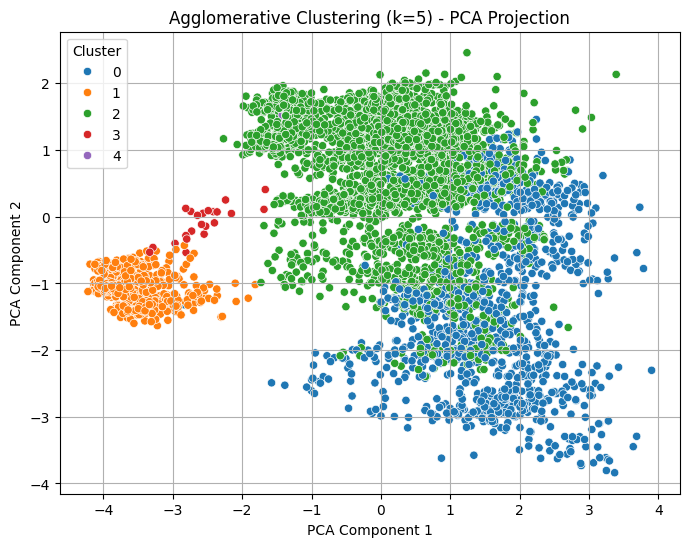

In [ ]:
# --------------------------
# Preprocess for Clustering
# --------------------------

# Drop 'id' and 'stroke' (target), keep features only
X = df.copy()
X = df.drop(columns=['id', 'stroke'])

# Scale all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------
# Run Agglomerative Clustering
# --------------------------

# Choose number of clusters (you can change n_clusters)
n_clusters = 5
agg = AgglomerativeClustering(n_clusters=n_clusters)
cluster_labels = agg.fit_predict(X_scaled)

# Add cluster assignments to original df
df['cluster'] = cluster_labels

# --------------------------
# Evaluate with Silhouette Score
# --------------------------

sil_score = silhouette_score(X_scaled, cluster_labels)
print(f"Silhouette Score for Agglomerative Clustering (k={n_clusters}): {sil_score:.2f}")

# --------------------------
# Stroke Distribution per Cluster
# --------------------------

print("\nStroke distribution per cluster:")
print(df.groupby('cluster')['stroke'].value_counts(normalize=True).unstack().fillna(0))

# --------------------------
# Visualize clusters in 2D using PCA
# --------------------------

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='tab10')
plt.title(f'Agglomerative Clustering (k={n_clusters}) - PCA Projection')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()
